In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer

### 전처리

#### 1. 하나의 샘플에 단어가 2개 이상 존재하지 않는 샘플 제거
⇒ 샘플당 최소한 단어 2개 이상 있어야 중심 단어, 주변 단어의 관계가 성립하기 때문

In [10]:
data = pd.read_csv('./naver_shopping.txt', sep = "\t",header=None,names=['ID','Review'])
print('총 샘플 수 :',len(data))

총 샘플 수 : 200000


In [11]:
data = data.drop(columns=['ID'], axis=1)
# 50000개 데이터만 추출
data = data.loc[0:49999]
data

,Review
0,배공빠르고 굿
1,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ
...,...
49995,겨울에 건조할때 이것만한게 없어요 아이들이 쓰는데 순하고 촉촉하고 너무좋아요~^^
49996,향이 넘 좋아요 다이어트 차로 유명하다구 해서 구매하구 꾸준히먹구 또 재구매했어요 ...
49997,재구매 선생님 오늘도 감사해요 ...쌤덕분에 잠시라도 친해져서 밥도먹고 빠르게 만났...
49998,재구매 연마제가 끊임없이 나와서 20번 이상 세척하고도 안되서 식용유로 일일이 하나...


In [12]:
# reviews 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Review'], inplace=True)
print('총 샘플 수 :',len(data))

총 샘플 수 : 49997


#### 결측치 확인

In [13]:
data.isnull().values.any()

False

#### 데이터 정제

In [14]:
# 한글과 공백을 제외하고 모두 제거
data['Review'] = data['Review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
data['Review'].replace('', np.nan, inplace=True) #빈칸은 결측치로 변환
data.isnull().sum() # 결측치 없음!

Review    0
dtype: int64

#### 토큰화 & 불용어 제거

In [15]:
# 형태소 분석기 OKT를 사용한 토큰화 작업
# Okt (구 Twitter): 오픈 소스 한국어 분석기이고, 과거 트위터 형태소 분석기
okt = Okt()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']
tokenized_doc = []
for sentence in data['Review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_doc.append(temp_X)

In [16]:
# 단어가 1개 이하인 경우 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1] # 단어가 1개 이하인 샘플의 인덱스 저장
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0) # 해당 샘플들 제거
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 49890


C:\Users\Jeon Jiwoo\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 5. 정수 인코딩

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [18]:
print(encoded[:2])

[[7312, 27, 272], [193, 545, 145, 115, 563, 198, 546, 1690, 326, 159, 1364]]


In [19]:
# 단어 집합의 크기
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21600


### 네거티브 샘플링

In [20]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

In [21]:
# 첫 번째 리뷰그룹 샘플 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[5][0], skip_grams[5][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(진짜 (82), 숙성하다 (6342)) -> 0
(불편하다 (111), 특특 (21390)) -> 0
(비추다 (284), 지못미 (12494)) -> 0
(실용 (1151), 보다도 (1757)) -> 0
(보기 (608), 액션 (3793)) -> 0


윈도우 크기 = 10 내에서  
중심 단어, 주변 단어의 관계를 갖는 경우 = 1  
중심 단어, 주변 단어의 관계를 갖지 않는 경우 = 0

In [22]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 49890


In [23]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

660
660


### Skip-Gram with Negative Sampling(SGNS) 구현

In [24]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [25]:
embed_size = 100 # 임의로 설정

In [26]:
# 임베딩 테이블 생성
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

1. 단어는 임베딩 테이블을 거치며 내적을 수행  
2. 내적의 결과에 대해 1 또는 0을 예측하기 위해 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값 계산

In [27]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       2160000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       2160000     input_2[0][0]                    
______________________________________________________________________________________________

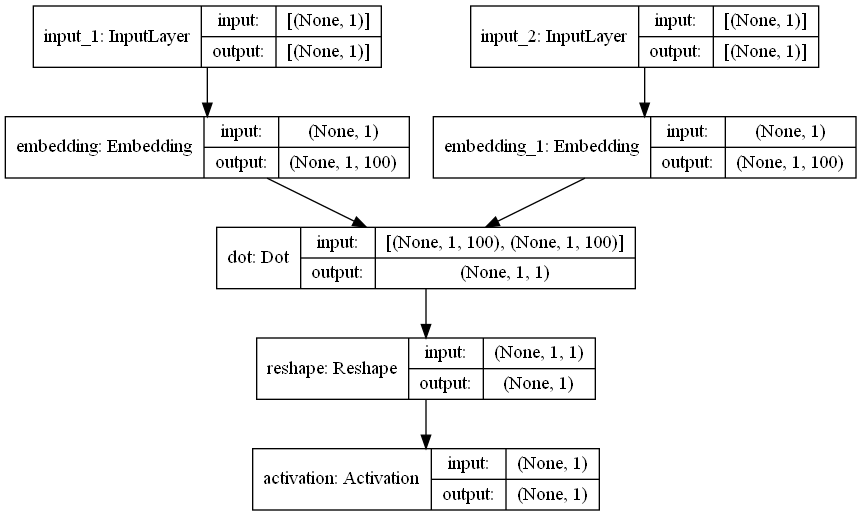

In [28]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [29]:
for epoch in range(1, 3):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 15784.405786621151
Epoch : 2 Loss : 14268.576180072734


### 결과 확인

In [30]:
import gensim
f = open('vectors_okt.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', encoding='cp949', binary=False)

In [49]:
w2v.most_similar(positive=['밤'])

[('비리다', 0.5968079566955566),
 ('찌다', 0.5607590079307556),
 ('속이다', 0.5586252808570862),
 ('고구마', 0.5548953413963318),
 ('식', 0.5418834686279297),
 ('기름', 0.5301826000213623),
 ('굽다', 0.5283915996551514),
 ('씨', 0.528059720993042),
 ('냉동', 0.5268831253051758),
 ('호박', 0.5259698629379272)]

In [50]:
w2v.most_similar(positive=['배터리'])

[('연결', 0.7366383075714111),
 ('아이폰', 0.7288424968719482),
 ('중간', 0.6770490407943726),
 ('보조', 0.6727166771888733),
 ('이어폰', 0.6710714101791382),
 ('핀', 0.6676031351089478),
 ('누르다', 0.6608299612998962),
 ('스크레치', 0.649871826171875),
 ('경우', 0.6466999650001526),
 ('결국', 0.6464872360229492)]

In [48]:
w2v.most_similar(positive=['고기'])

[('맵다', 0.6681540012359619),
 ('양념', 0.64952552318573),
 ('맛', 0.6467909812927246),
 ('야채', 0.6226661801338196),
 ('맛있다', 0.6174620389938354),
 ('호박', 0.6093883514404297),
 ('비리다', 0.6017285585403442),
 ('입맛', 0.594268798828125),
 ('신선하다', 0.5822972059249878),
 ('먹다', 0.5815186500549316)]

In [51]:
w2v.most_similar(positive=['선물'],topn = 5)

[('생일', 0.6433972716331482),
 ('사주다', 0.6369302272796631),
 ('친구', 0.6067937612533569),
 ('부모님', 0.5845746994018555),
 ('좋아하다', 0.5761808156967163)]